In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
import random
import swifter
from sklearn.preprocessing import LabelEncoder
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import auc
import pickle
import statsmodels.formula.api as smf
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [166]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [167]:
hackathon_womens = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv")
hackathon_scouting = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv")
hackathon_nwhl = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_nwhl.csv")

In [168]:
start_data = hackathon_scouting.copy()
start_data.shape

(75873, 21)

In [169]:
data_array = np.array(start_data)
preData = pd.DataFrame(data_array, columns=start_data.columns)
preData.head()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN
1,2019-09-20,Erie Otters,Sudbury Wolves,1,19:58,5,5,0,0,Sudbury Wolves,Emmett Serensits,Puck Recovery,67,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,Sudbury Wolves,Emmett Serensits,Incomplete Play,45,49,Direct,NaN,NaN,NaN,Blake Murray,74,35
3,2019-09-20,Erie Otters,Sudbury Wolves,1,19:52,5,5,0,0,Erie Otters,Hayden Fowler,Puck Recovery,89,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,Erie Otters,Hayden Fowler,Incomplete Play,82,49,Direct,NaN,NaN,NaN,Connor Lockhart,94,46


In [170]:
currGame = None
prevGame = None
currPossNum = {}
currPossTeam = None
prevPossTeam = None
currPlayNum = 0
currEvent = None
nextEvent = None
prevPeriod = None
currPeriod = 0
possInitiatedEventGlobal = ''
numShots = 0
numPlays = 0
numIncompletePlays = 0
numZoneEntries = 0

possNums = np.zeros(len(preData))
possEnd = ['' for i in range(len(preData))]
possEndReasons = ['' for i in range(len(preData))]
possInitiatedArr = [False for i in range(len(preData))]
possInitiatedEventArr = ['' for i in range(len(preData))]
playNumberArr = np.zeros(len(preData))
numShotsArr = np.zeros(len(preData))
numPlaysArr = np.zeros(len(preData))
numIncompletePlaysArr = np.zeros(len(preData))
numZoneEntriesArr = np.zeros(len(preData))

for i, row in enumerate(data_array):
    possEndReason = ''
    possInitiatedEvent = ''
    currGame = row[0]
    currPossTeam = row[9]
    checkNextPlay = True
    currEvent = row[11]
    currPeriod = row[3]
    
    if (currGame != prevGame) or (currPossTeam != prevPossTeam) or (prevPeriod != currPeriod):
        if (currGame != prevGame) or (prevPeriod != currPeriod):
            currPossNum = {}
            prevPossTeam = None
        if (currPossTeam not in currPossNum):
            currPossNum[currPossTeam] = 0
        prevPeriod = currPeriod
        possInitiatedEvent = currEvent
        currPossNum[currPossTeam] += 1
        prevPossTeam = currPossTeam
        prevGame = currGame
        currPlayNum = 1
        numShots = 0
        numPlays = 0
        numIncompletePlays = 0
        numZoneEntries = 0
    else:
        currPlayNum += 1
        
    # if a penalty was taken, make sure that the next play is signified as the possession start
    if (currEvent == 'Penalty Taken'):
        currPlayNum = 1
        possInitiatedEvent = data_array[i+1][11]
        checkNextPlay = False
    elif (i > 0) and (data_array[i-1][0] == currGame) and (data_array[i-1][11] == 'Penalty Taken'):
        possInitiatedEvent = currEvent
        
    possInitiatedEventGlobal = possInitiatedEvent if (possInitiatedEvent) else possInitiatedEventGlobal
    
    # Check if next play signifies this is the last play of possession
    if (checkNextPlay) and (i < len(data_array) - 1) and (currGame == data_array[i+1][0]):
        if (data_array[i+1][11] == 'Penalty Taken'):
            if(currPossTeam != data_array[i+1][11]):
                possEndReason = "Opponent Penalty Taken"
            else:
                possEndReason = "Penalty Taken"
        if (data_array[i+1][11] == 'Faceoff Win'):
            possEndReason = "Faceoff Occured"
        if (currPossTeam != data_array[i+1][9]):
            possEndReason = data_array[i+1][11]
    elif not(checkNextPlay):
        possEndReason = ''
        possInitiatedEvent = ''
    elif (i == len(data_array) - 1) or (currGame != data_array[i+1][0]):
        possEndReason = 'endOfGame'
    elif (row[3] != data_array[i+1][3]):
        possEndReason = 'endOfPeriod'
        
    if (currEvent == 'Goal'):
        possEndReason = 'Goal'
    elif (currEvent == 'Shot'):
        if (possEndReason) and (possEndReason != 'endOfGame') and (data_array[i+1][11] != 'Puck Recovery'):
            possEndReason = 'Missed Shot'
        numShots += 1
    if (currEvent == 'Play'):
        numPlays += 1
    elif (currEvent == 'Incomplete Play'):
        numIncompletePlays += 1
    elif (currEvent == 'Zone Entry'):
        numZoneEntries += 1
    
    possNums[i] = currPossNum[currPossTeam]
    possEnd[i] = True if (possEndReason) else False
    possEndReasons[i] = possEndReason
    possInitiatedArr[i] = True if (possInitiatedEvent) else False
    possInitiatedEventArr[i] = possInitiatedEventGlobal
    playNumberArr[i] = currPlayNum
    numShotsArr[i] = numShots
    numPlaysArr[i] = numPlays
    numIncompletePlaysArr[i] = numIncompletePlays
    numZoneEntriesArr[i] = numZoneEntries

In [171]:
preData['possNum'] = possNums
preData['possEnd'] = possEnd
preData['possEndReasons'] = possEndReasons
preData['possInitiated'] = possInitiatedArr
preData['possInitiatedEvent'] = possInitiatedEventArr
preData['eventNumber'] = playNumberArr
preData['numShots'] = numShotsArr
preData['numPlays'] = numPlaysArr
preData['numIncompletePlays'] = numIncompletePlaysArr
preData['numZoneEntries'] = numZoneEntriesArr
preData.sample()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,possNum,possEnd,possEndReasons,possInitiated,possInitiatedEvent,eventNumber,numShots,numPlays,numIncompletePlays,numZoneEntries
7627,2019-10-11,Erie Otters,Hamilton Bulldogs,1,19:46,5,5,0,0,Erie Otters,Danial Singer,Zone Entry,101,82,Dumped,NaN,NaN,NaN,Kade Landry,NaN,NaN,1.0,True,Puck Recovery,False,Puck Recovery,7.0,0.0,3.0,0.0,1.0


In [177]:
posEnds = preData[preData.possEnd == True].groupby(['game_date', 'Home Team', 'Away Team', 'Team', 'Period', 'possNum'])[['possEndReasons',
                                        'eventNumber', 'numPlays', 'numShots', 'numIncompletePlays', 
                                        'numZoneEntries']].max().reset_index()
posEnds.columns = ['game_date', 'Home Team', 'Away Team', 'Team', 'Period', 'possNum', 'possessionEndReasons', 'totalEventsInPoss', 'totalNumPlaysInPoss', 
                   'totalNumShotsInPoss', 'totalNumIncompletePlaysInPoss', 'totalNumZoneEntriesInPoss']
posEnds.sample()

,game_date,Home Team,Away Team,Team,Period,possNum,possessionEndReasons,totalEventsInPoss,totalNumPlaysInPoss,totalNumShotsInPoss,totalNumIncompletePlaysInPoss,totalNumZoneEntriesInPoss
7897,2019-12-13,Sudbury Wolves,Erie Otters,Sudbury Wolves,3,60.0,Takeaway,1.0,0.0,0.0,0.0,0.0


In [277]:
data = preData.merge(posEnds, on=['game_date', 'Home Team', 'Away Team', 'Team', 'Period', 'possNum'], how='left')
data.sample(5)

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,possNum,possEnd,possEndReasons,possInitiated,possInitiatedEvent,eventNumber,numShots,numPlays,numIncompletePlays,numZoneEntries,possessionEndReasons,totalEventsInPoss,totalNumPlaysInPoss,totalNumShotsInPoss,totalNumIncompletePlaysInPoss,totalNumZoneEntriesInPoss
51036,2020-01-18,Windsor Spitfires,Erie Otters,3,14:18,5,5,3,2,Windsor Spitfires,Dylan Robinson,Takeaway,33,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,False,,True,Takeaway,1.0,0.0,0.0,0.0,0.0,Takeaway,2.0,0.0,0.0,1.0,0.0
44603,2020-01-11,Erie Otters,Niagara Ice Dogs,1,0:49,5,5,1,0,Erie Otters,Emmett Sproule,Incomplete Play,186,75,Direct,NaN,NaN,NaN,Hayden Fowler,163,61,70.0,True,Puck Recovery,False,Puck Recovery,7.0,1.0,2.0,1.0,1.0,Puck Recovery,7.0,2.0,1.0,1.0,1.0
50678,2020-01-18,Windsor Spitfires,Erie Otters,2,5:52,5,4,2,2,Windsor Spitfires,Cole Purboo,Incomplete Play,177,18,Direct,NaN,NaN,NaN,Ruben Rafkin,129,23,39.0,True,Puck Recovery,False,Puck Recovery,13.0,1.0,6.0,2.0,0.0,Puck Recovery,13.0,6.0,1.0,2.0,0.0
22827,2019-11-09,Barrie Colts,Erie Otters,3,14:40,5,5,1,4,Barrie Colts,Tyler Tucker,Play,138,80,Direct,NaN,NaN,NaN,Ryan Del Monte,183,82,28.0,False,,False,Takeaway,2.0,0.0,1.0,0.0,0.0,Puck Recovery,7.0,3.0,2.0,0.0,0.0
8352,2019-10-11,Erie Otters,Hamilton Bulldogs,2,16:33,5,5,0,1,Erie Otters,Hayden Fowler,Puck Recovery,173,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,False,,False,Puck Recovery,5.0,0.0,1.0,0.0,1.0,Puck Recovery,15.0,7.0,0.0,1.0,2.0


In [278]:
data['newClock'] = np.array([int(i[0])*60 + int(i[1]) for i in data.Clock.str.split(':')]) / 1200
data['numExtraSkaters'] =( np.where(data['Home Team'] == data['Team'], 
                                   data['Home Team Skaters'] - data['Away Team Skaters'],
                                  data['Away Team Skaters'] - data['Home Team Skaters'])).astype(int)

In [279]:
data.columns

Index(['game_date', 'Home Team', 'Away Team', 'Period', 'Clock',
       'Home Team Skaters', 'Away Team Skaters', 'Home Team Goals',
       'Away Team Goals', 'Team', 'Player', 'Event', 'X Coordinate',
       'Y Coordinate', 'Detail 1', 'Detail 2', 'Detail 3', 'Detail 4',
       'Player 2', 'X Coordinate 2', 'Y Coordinate 2', 'possNum', 'possEnd',
       'possEndReasons', 'possInitiated', 'possInitiatedEvent', 'eventNumber',
       'numShots', 'numPlays', 'numIncompletePlays', 'numZoneEntries',
       'possessionEndReasons', 'totalEventsInPoss', 'totalNumPlaysInPoss',
       'totalNumShotsInPoss', 'totalNumIncompletePlaysInPoss',
       'totalNumZoneEntriesInPoss', 'newClock', 'numExtraSkaters'],
      dtype='object')

In [280]:
def calcAngle(row):
    angle = 90
    deltaX = (row['X Coordinate'] - row['X Coordinate 2'])
    deltaY = (row['Y Coordinate'] - row['Y Coordinate 2'])
    if (deltaX != 0):
        angle = np.arctan(deltaY / deltaX) * 180 / math.pi
    return angle

In [282]:
passData = data[data.Event.isin(['Incomplete Play', 'Play'])].copy()
passData['passDeltaX'] = (passData['X Coordinate 2'] - passData['X Coordinate'])
passData['passDeltaY'] = (passData['Y Coordinate 2'] - passData['Y Coordinate'])
passData['passDist'] = ((np.abs(passData['passDeltaX'])**2 + np.abs(passData['passDeltaY'])**2)**(1/2)).astype(float)
passData['forwardPass'] = np.where((passData['X Coordinate 2'] - passData['X Coordinate'] > 0), 1, 0).astype(int)
passData['passDestSide'] = np.where((passData['Y Coordinate 2'] > (85/3)), 
                                    np.where((passData['Y Coordinate 2'] > (85/3)*2), 'left', 'middle'), 'right')
passData['passAngle'] = passData.apply(lambda x: calcAngle(x), axis=1)
passData['successfulPass'] = (passData.Event == 'Play').astype(int)
passData.head()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,possNum,possEnd,possEndReasons,possInitiated,possInitiatedEvent,eventNumber,numShots,numPlays,numIncompletePlays,numZoneEntries,possessionEndReasons,totalEventsInPoss,totalNumPlaysInPoss,totalNumShotsInPoss,totalNumIncompletePlaysInPoss,totalNumZoneEntriesInPoss,newClock,numExtraSkaters,passDeltaX,passDeltaY,passDist,forwardPass,passDestSide,passAngle,successfulPass
2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,Sudbury Wolves,Emmett Serensits,Incomplete Play,45,49,Direct,NaN,NaN,NaN,Blake Murray,74,35,1.0,True,Puck Recovery,False,Faceoff Win,3.0,0.0,0.0,1.0,0.0,Puck Recovery,3.0,0.0,0.0,1.0,0.0,0.994167,0,29,-14,32.202484,1,middle,-25.769328,0
4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,Erie Otters,Hayden Fowler,Incomplete Play,82,49,Direct,NaN,NaN,NaN,Connor Lockhart,94,46,1.0,True,Puck Recovery,False,Puck Recovery,2.0,0.0,0.0,1.0,0.0,Puck Recovery,2.0,0.0,0.0,1.0,0.0,0.992500,0,12,-3,12.369317,1,middle,-14.036243,0
6,2019-09-20,Erie Otters,Sudbury Wolves,1,19:45,5,5,0,0,Sudbury Wolves,Emmett Serensits,Play,6,60,Indirect,NaN,NaN,NaN,Blake Murray,29,2,2.0,False,,False,Puck Recovery,2.0,0.0,1.0,0.0,0.0,Puck Recovery,6.0,2.0,0.0,0.0,1.0,0.987500,0,23,-58,62.393910,1,right,-68.369113,1
8,2019-09-20,Erie Otters,Sudbury Wolves,1,19:38,5,5,0,0,Sudbury Wolves,Blake Murray,Play,82,50,Indirect,NaN,NaN,NaN,Owen Gilhula,82,54,2.0,False,,False,Puck Recovery,4.0,0.0,2.0,0.0,0.0,Puck Recovery,6.0,2.0,0.0,0.0,1.0,0.981667,0,0,4,4.000000,0,middle,90.000000,1
12,2019-09-20,Erie Otters,Sudbury Wolves,1,19:32,5,5,0,0,Erie Otters,Jamie Drysdale,Play,9,74,Indirect,NaN,NaN,NaN,Kurtis Henry,4,29,2.0,False,,False,Puck Recovery,2.0,0.0,1.0,0.0,0.0,Puck Recovery,4.0,2.0,0.0,1.0,0.0,0.976667,0,-5,-45,45.276926,0,middle,83.659808,1


In [301]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
passData['passType'] = lb.fit_transform(passData['Detail 1'])
passData['passDestSide'] = lb.fit_transform(passData['passDestSide'])
passData['normX'] = (passData['X Coordinate'] / 200).astype(float)
passData['normY'] = (passData['Y Coordinate'] / 85).astype(float)
passData['normX2'] = (passData['X Coordinate 2'] / 200).astype(float)
passData['normY2'] = (passData['Y Coordinate 2'] / 85).astype(float)
passData['normPassDist'] = (passData['passDist'] / passData['passDist'].mean()).astype(float)

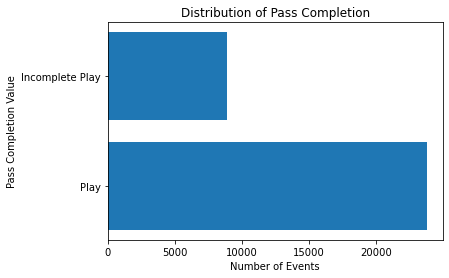

In [284]:
plt.barh(passData.Event.value_counts().index, passData.Event.value_counts())
plt.xlabel('Number of Events')
plt.ylabel('Pass Completion Value')
plt.title('Distribution of Pass Completion')
plt.savefig('Distribution of Pass Completion')

In [307]:
def plotCalibGraph(calibData, saveFig=''):
    fig, ax = plt.subplots(figsize=(7,7))
    sizes = calibData.NumAttempts / calibData.NumAttempts.mean() * 200
    y2s = lowess(calibData.actualCompPct, calibData.binEstim)[:,1]
    ax.plot([0, 1], [0, 1], linestyle='--', c='k')
    ax.scatter(calibData.binEstim, calibData.actualCompPct, c='b', s=sizes)
    ax.plot(calibData.binEstim, y2s, c='b', linewidth=4, alpha=0.5)
    ax.set_xlabel('Predicted Percentage')
    ax.set_ylabel('Actual Percentage')
    ax.set_title("Pass Completion Percentage")
    if saveFig:
        plt.savefig(saveFig)
    plt.show()
def calibrateModel(phatComplete, ytest):
    calibData = pd.DataFrame(ytest).reset_index().drop('index', axis=1)
    calibData.columns = ['result']
    calibData['estimatedCompProb'] = phatComplete
    calibData['binEstim'] = round(test['estimatedCompProb'] / 0.05) * 0.05
    
    finalCalibData = calibData.groupby(['binEstim']).agg({'result': ['sum', 'count']}).reset_index()
    finalCalibData.columns = ['binEstim', 'TotalCompletions', 'NumAttempts']
    finalCalibData['actualCompPct'] = finalCalibData['TotalCompletions'] / finalCalibData['NumAttempts']
    finalCalibData['calibError'] = np.abs(finalCalibData['binEstim'] - finalCalibData['actualCompPct'])
    return finalCalibData
def doCVPass(XInput, yInput, model, iters, plotGraph=False, saveFig=''):
    calibErrors = []
    for i in range(0, iters):
        modelToUse = model
        Xtrain, Xval, ytrain, yval = train_test_split(XInput,
                                                        yInput, test_size=0.2)
        model.fit(Xtrain, ytrain)
        phat = model.predict_proba(Xval)
        calibData = calibrateModel(phat[:,1], yval)
        if plotGraph:
            plotCalibGraph(calibData, saveFig)
        calibErrors.append(calibData.calibError.mean())
    return calibErrors, calibData

In [305]:
Xtrain, Xtest, ytrain, ytest = train_test_split(passData[['passAngle', 'normPassDist', 
                                                          'normX', 'normY', 'normX2', 'normY2',
                                                          'passType', 'numExtraSkaters']], 
                                                passData.successfulPass, test_size=0.2)

In [295]:
sm = SMOTE(random_state=2013)
Xtrain2, ytrain2 = sm.fit_resample(Xtrain, ytrain)
Xtrain = pd.DataFrame(Xtrain2, columns=Xtrain.columns)
ytrain = ytrain2

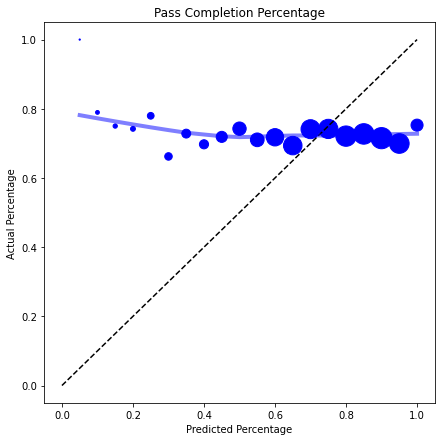

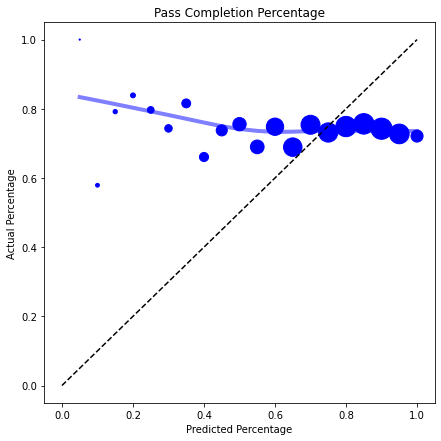

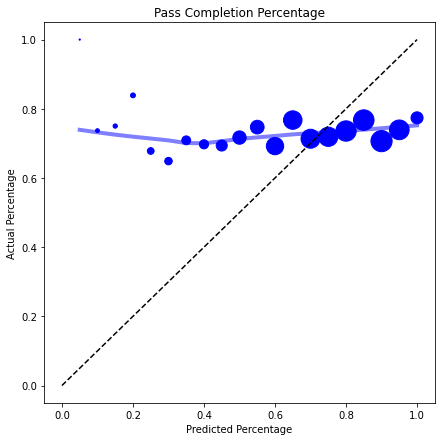

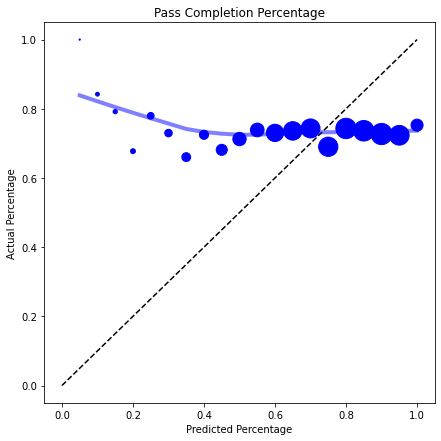

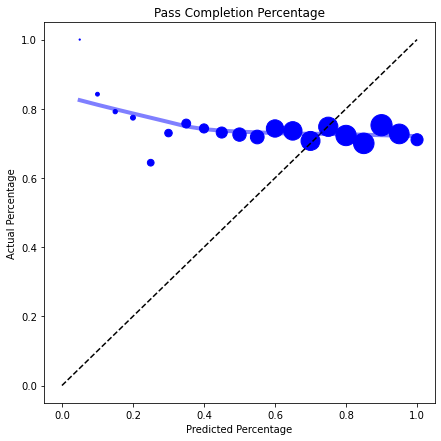

CV Calibration Error: 0.3069095367347635


In [306]:
xgboost = XGBClassifier(booster='gbtree', eval_metric='logloss', gamma=5, objective='binary:logistic', base_score=passData.successfulPass.mean())
calibErrors, calibData = doCVPass(Xtrain, ytrain, xgboost, 5, True, '')
print('CV Calibration Error:', sum(calibErrors) / len(calibErrors))

In [293]:
forest = RandomForestClassifier(random_state=2013, n_jobs=-1)
calibErrors, calibData = doCVPass(Xtrain, ytrain, forest, 5, False, '')
print('CV Calibration Error:', sum(calibErrors) / len(calibErrors))
#plt.barh(Xtrain.columns, forest.feature_importances_)

CV Calibration Error: 0.3013931374282489


In [191]:
for i in [10, 20, 50, 70, 100, 250, 500, 1000]:
    print('Num Estims:', i)
    newForest = RandomForestClassifier(random_state=2013, n_estimators=i, n_jobs=-1)
    calibErrors = doCVPass(Xtrain, ytrain, newForest, 5, False, '')
    print('CV Calibration Error:', sum(calibErrors) / len(calibErrors))

Num Estims: 10
CV Calibration Error: 0.26212800892288796
Num Estims: 20
CV Calibration Error: 0.2597796346630493
Num Estims: 50
CV Calibration Error: 0.2561916135666169
Num Estims: 70
CV Calibration Error: 0.2544989484897889
Num Estims: 100
CV Calibration Error: 0.25820981514889235
Num Estims: 250


KeyboardInterrupt: 

In [148]:
for i in [None, 5, 10, 15, 20, 30]:
    print('Max Depth:', i)
    newForest = RandomForestClassifier(random_state=2013, n_estimators=70, max_depth=i, n_jobs=-1)
    calibErrors = doCVPass(Xtrain, ytrain, newForest, 5, False, '')
    print('CV Calibration Error:', sum(calibErrors) / len(calibErrors))

Max Depth: None
CV Calibration Error: 0.2749523454965421
Max Depth: 5
CV Calibration Error: 0.29019380445534315
Max Depth: 10
CV Calibration Error: 0.2903326661308526
Max Depth: 15
CV Calibration Error: 0.27623464506415935
Max Depth: 20
CV Calibration Error: 0.30072796924220285
Max Depth: 30
CV Calibration Error: 0.29660949956108607


In [54]:
for i in ['gini', 'entropy']:
    print('Criterion:', i)
    newForest = RandomForestClassifier(random_state=2013, n_estimators=250, max_depth=20, criterion=i, n_jobs=-1)
    calibErrors = doCVPass(Xtrain, ytrain, newForest, 5, False, '')
    print('CV Calibration Error:', sum(calibErrors) / len(calibErrors))

Criterion: gini
CV fscores: 0.7986234164858328
CV Prec/Recall AUC: 0.8739808555508416
Criterion: entropy
CV fscores: 0.8015946453153051
CV Prec/Recall AUC: 0.8769910213322664


In [55]:
for i in ['auto', 'sqrt', 'log2']:
    print('Max Features:', i)
    newForest = RandomForestClassifier(random_state=2013, n_estimators=250, max_depth=20, criterion='entropy',
                                       max_features=i, n_jobs=-1)
    fscores, aucVals = doCVPass(Xtrain, ytrain, newForest, 5, False)
    print('CV fscores:', sum(fscores) / len(fscores))
    print('CV Prec/Recall AUC:', sum(aucVals) / len(aucVals))

Max Features: auto
CV fscores: 0.7991040182636426
CV Prec/Recall AUC: 0.8738603761049101
Max Features: sqrt
CV fscores: 0.8017810121327387
CV Prec/Recall AUC: 0.8738144930711739
Max Features: log2
CV fscores: 0.7965468533363241
CV Prec/Recall AUC: 0.8729546340220218


In [56]:
for i in [2, 3, 4, 5, 7, 10]:
    print('Min Samples Split:', i)
    newForest = RandomForestClassifier(random_state=2013, n_estimators=250, max_depth=20, criterion='entropy',
                                       max_features='sqrt', min_samples_split=i, n_jobs=-1)
    fscores, aucVals = doCVPass(Xtrain, ytrain, newForest, 5, False)
    print('CV fscores:', sum(fscores) / len(fscores))
    print('CV Prec/Recall AUC:', sum(aucVals) / len(aucVals))

Min Samples Split: 2
CV fscores: 0.7986020312144728
CV Prec/Recall AUC: 0.8697956871198442
Min Samples Split: 3
CV fscores: 0.7973755325689285
CV Prec/Recall AUC: 0.8681223994391207
Min Samples Split: 4
CV fscores: 0.7935051071531423
CV Prec/Recall AUC: 0.8672501560586244
Min Samples Split: 5
CV fscores: 0.7945173802602906
CV Prec/Recall AUC: 0.8684743845963154
Min Samples Split: 7
CV fscores: 0.7918996891527115
CV Prec/Recall AUC: 0.8659644481655343
Min Samples Split: 10
CV fscores: 0.7864589623504477
CV Prec/Recall AUC: 0.8605242014947635


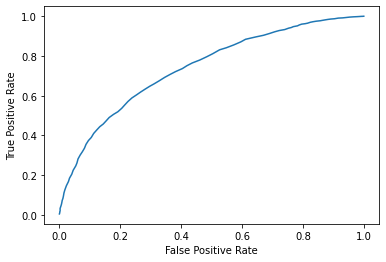

Default fscore: 0.5181397613830047
Prec/Recall AUC: 0.8620486998072936
Best fscore: 0.5282863608311047 Threshold: 0.42424242424242425


In [89]:
finalPassModel = RandomForestClassifier(random_state=2013, n_estimators=250, max_depth=15, criterion='entropy',
                                       max_features='sqrt', min_samples_split=2, n_jobs=-1)
finalPassModel.fit(Xtrain, ytrain)
phat = finalPassModel.predict_proba(Xtest)
yhat = finalPassModel.predict(Xtest)
fscore = f1_score(np.array(yhat)*-1 + 1, np.array(ytest)*-1 + 1)#f1_score(ytest, yhat)
aucVal = calcAUC(phat[:,1], np.array(ytest), True, True, '')
print('Default fscore:', fscore)
print('Prec/Recall AUC:', sum(aucVals) / len(aucVals))
thresholds = np.linspace(0,1, 100)
fscoreThresh = [f1_score(np.array(ytest)*-1 + 1, np.where(phat[:,0] >= thresh, 1, 0)) for thresh in thresholds]
bestThreshLoc = np.argmax(fscoreThresh)
print('Best fscore:', fscoreThresh[bestThreshLoc], 'Threshold:', thresholds[bestThreshLoc])

In [ ]:
finalCPX = passData[['passAngle', 'Period', 'newClock', 'passDist', 
                      'normX', 'normY', 'normX2', 'normY2', 'passType']]
finalCPY = passData['successfulPass']
finalPassModel = RandomForestClassifier(random_state=2013, n_estimators=250, max_depth=15, criterion='entropy',
                                       max_features='sqrt', min_samples_split=4, n_jobs=-1)
finalPassModel.fit(finalCPX, finalCPY)
phat = finalPassModel.predict_proba(finalCPX)
plt.barh(finalCPX.columns, finalPassModel.feature_importances_)
plt.savefig('EC Feature importance')

In [ ]:
expectedPassCompletionArr = phat[:,1]

In [ ]:
afterData = data.copy()
afterData['ePC'] = -1
afterData.loc[afterData.Event.isin(['Play', 'Incomplete Play']), 'ePC'] = expectedPassCompletionArr

In [ ]:
afterPassData = afterData[afterData.Event.isin(['Play', 'Incomplete Play'])].copy()
afterPassData.sample(5)

In [86]:
def calcAUCHelper(thresholds, phat, yactual):
    precisions = []
    recalls = []
    fpRates = []
    for threshold in thresholds:
        yhat = []
        for prediction in phat:
            y = 0 if prediction < threshold else 1
            yhat.append(y)
        fp = 0
        tp = 0
        fn = 0
        tn = 0
        for i in range(0, len(yactual)):
            if yactual[i] == yhat[i]:
                if yactual[i] == 1:
                    tp += 1
                else:
                    tn += 1
            elif yactual[i] != yhat[i]:
                if yactual[i] == 1:
                    fn += 1
                else:
                    fp += 1
        recall = tp / (tp + fn)
        prec = 0
        if (fp > 0) or (tp > 0):
            prec = tp / (tp + fp)
        fpRate = (fp / (tn + fp))
        precisions.append(prec)
        recalls.append(recall)
        fpRates.append(fpRate)
    return precisions, recalls, fpRates
def calcAUC(phat, yactual, plotGraph=False, roc=False, saveFig=''):
    thresholds = np.linspace(0, 1, 100)
    precision, recall, fpRates = calcAUCHelper(thresholds, phat, yactual)
    if(plotGraph):
        if roc:
            plt.plot(fpRates, recall)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
        else:
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
        if saveFig:
            plt.savefig(saveFig)
        plt.show()
    precision = np.array(precision)
    recall = np.array(recall)
    fpRates = np.array(fpRates)
    if roc:
        auc(fpRates, recall)
    return auc(recall, precision)
def doCVPass(XInput, yInput, model, iters, plotGraph=False, roc=False):
    fscores = []
    aucs = []
    for i in range(0, iters):
        modelToUse = model
        Xtrain, Xval, ytrain, yval = train_test_split(XInput,
                                                        yInput, test_size=0.2)
        model.fit(Xtrain, ytrain)
        phat = model.predict_proba(Xval)
        
    return fscores, aucs